#   DTEK0087 
#   Analysis and Programming for Health Wearables 2021

Lauri Orava

516761

Analysis exercise 1

In [69]:
import pandas as pd
import numpy as np 
import scipy.signal as signal
from scipy import interpolate
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
# 1 - Read data

data = os.path.join(os.getcwd(), 'data', 'ecg_ppg_motion.csv')
df = pd.read_csv(data)

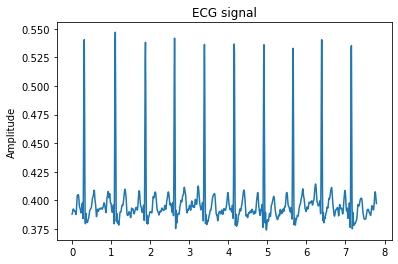

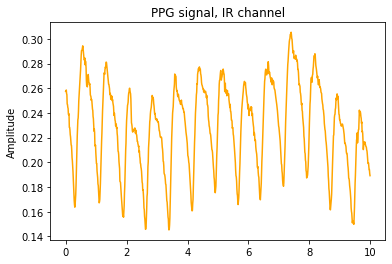

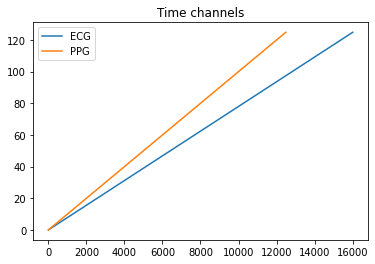

In [71]:
# 1 - Pre-clean data and convert to numpy then plot

# Simple min-max normalization method
def normalize(sig):
    sig = sig - np.min(sig)
    sig = sig / np.max(sig)
    return sig

# Drop NaN values
# Convert to numpy
# Normalize with min-max normalization
ecg_signal = normalize(df['ecg'].dropna().to_numpy(dtype='float'))
ir_signal = normalize(df['ppg_1_ir'].dropna().to_numpy(dtype='float') * -1)

# Drop NaN values
# Convert to numpy
# Time set to start from 0, and is scaled to nanoseconds
ecg_time = (df['timestamps_ecg'].dropna().to_numpy(dtype='float') - df['timestamps_ecg'][0]) / 10000
ir_time = (df['timestamps_ppg_1_ir'].dropna().to_numpy(dtype='float') - df['timestamps_ppg_1_ir'][0]) / 10000

# Plot
plt.plot(ecg_time[:1000],ecg_signal[:1000])
plt.title('ECG signal')
plt.ylabel('Amplitude')
plt.show()
plt.close()
plt.plot(ir_time[:1000], ir_signal[:1000], color='orange')
plt.title('PPG signal, IR channel')
plt.ylabel('Amplitude')
plt.show()
plt.close()
plt.plot(ecg_time)
plt.plot(ir_time)
plt.title('Time channels')
plt.legend(['ECG', 'PPG'])
plt.show()
plt.close()

# 1 - Visual inspection
- All values are between 0 and 1 >> min-max normalization works
- The ECG and PPG signals look as expected, based on earlier knowledge about biosignals

In [72]:
# 2 -  Resampling

def spliner(ind_orig, val_orig, new_ind):
    spline_fn = interpolate.interp1d(ind_orig, val_orig, kind='cubic')
    return spline_fn(new_ind)

fs = 200
dt = 1/fs
T = min(ecg_time[-1], ir_time[-1])
n = fs*T
new_timestamps = np.arange(n)*dt

resampled_ecg = spliner(ecg_time, ecg_signal, new_timestamps)
resampled_ir = spliner(ir_time, ir_signal, new_timestamps)

# Alternate signal.resample() version
# Turned out to be not so smooth, because of how resample() works

# find the number of needed new time stamps
#fs = 200
#T = min(ecg_time[-1],ir_time[-1])
#n = int(fs*T)


# signal.resample returns [signal, timestamps]
# resample requires number of new points, and the old timestamps
#resampled_ecg = signal.resample(ecg_signal, n, ecg_time)
#resampled_ir = signal.resample(ir_signal, n, ir_time)

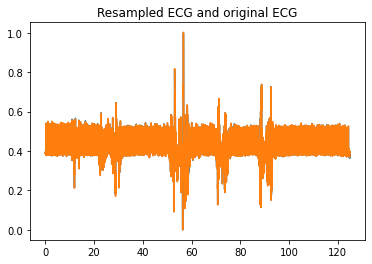

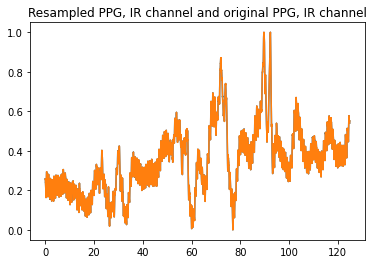

In [73]:
# 2 - Plotting the resampled signals
# It would be more fun to visually inspect these if the interactive plots worked in VSCode :(

plt.plot(ecg_time, ecg_signal)
plt.plot(new_timestamps, resampled_ecg)
plt.title('Resampled ECG and original ECG')
plt.show()
plt.close()
plt.plot(ir_time, ir_signal)
plt.plot(new_timestamps, resampled_ir)
plt.title('Resampled PPG, IR channel and original PPG, IR channel')
plt.show()
plt.close()

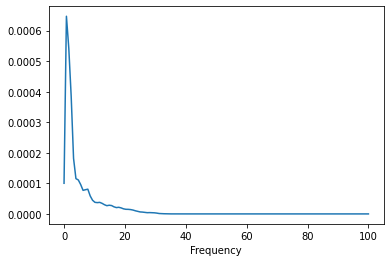

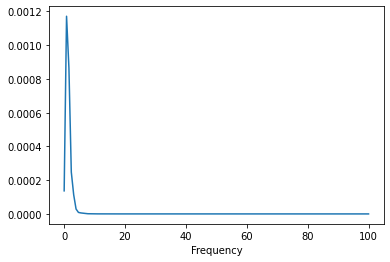

In [76]:
# 3 - Visualizing the signal in the frequency domain

freq_ecg = signal.welch(resampled_ecg, fs=fs)
freq_ir = signal.welch(resampled_ir, fs=fs)
plt.plot(freq_ecg[0], freq_ecg[1])
plt.xlabel('Frequency')
plt.show()
plt.close()
plt.plot(freq_ir[0], freq_ir[1])
plt.xlabel('Frequency')
plt.show()
plt.close()

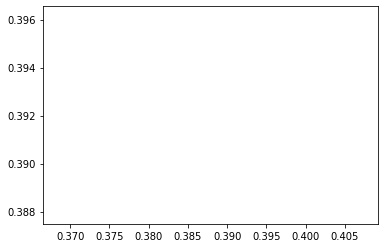

In [85]:
# 4 - Filtering

def butter_bandpass_filter(lowcut, highcut, freq, order, data):
    sampling_rate = 0.5*freq
    b,a = signal.butter(order, [lowcut/sampling_rate, highcut/sampling_rate], btype='band')
    y = signal.lfilter(b,a,data)
    return y

buttered_ecg = butter_bandpass_filter(40, 0.5, freq=fs, order=2, data=resampled_ecg)

plt.plot(resampled_ecg[1], resampled_ecg[0])
plt.plot(resampled_ecg[1], buttered_ecg[0])
plt.show()